In [2]:
import numpy as np
#cimport numpy as np
import h5py
import matplotlib.pyplot as plt
import MSMRD.trajectories.trajectoryTools as trajTools
%matplotlib inline

In [1]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [3]:
%%time
numfiles = 52
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/box/2DasymTrajsLong_B6_RT1E7_dt001_SI10'
samplingInterval = 10
dimension = 2
minima = np.array([[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]])
discretizer = trajTools.trajDiscretizationCython(minima, 2.5)
trajs = []
fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[::1,1:dimension+1]
    fullDTrajs.append(discretizer.getdTrajs([traj]))
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True)
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj

19.2307692308% done
38.4615384615% done
57.6923076923% done
76.9230769231% done
96.1538461538% done
CPU times: user 19min 18s, sys: 1.5 s, total: 19min 19s
Wall time: 19min 40s


In [4]:
%%time
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)

CPU times: user 16.1 s, sys: 104 ms, total: 16.2 s
Wall time: 16.2 s


In [5]:
%%time
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)

CPU times: user 8.96 s, sys: 8 ms, total: 8.96 s
Wall time: 9 s


In [160]:
exitTimesBenchmark = np.array(pickle.load(open('exitTimes_state4.p', 'r')))
exitTimesArray = np.array(exitTimes[4], dtype=float)*0.01

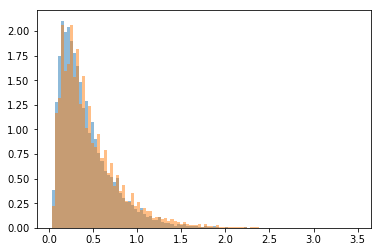

In [161]:
hist1 = plt.hist(exitTimesBenchmark, bins=100, alpha=0.5, normed=True)
hist2 = plt.hist(exitTimesArray, bins=hist1[1], alpha=0.5, normed=True)

In [162]:
print np.mean(exitTimesBenchmark)
print np.mean(exitTimesArray)

0.417155453822
0.464015616775


In [73]:
%%time
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

CPU times: user 9.17 s, sys: 108 ms, total: 9.28 s
Wall time: 9.28 s


247
281
335
319
326
278
304
299
358


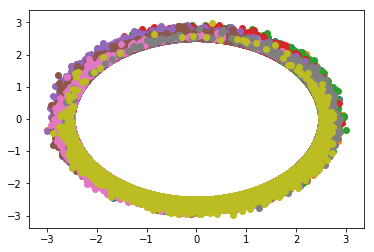

In [93]:
for i in range(9):
    plt.scatter(np.array(exitPositions[i])[:,0], np.array(exitPositions[i])[:,1])
for i in range(9):
    print np.amax(exitTimes[i])

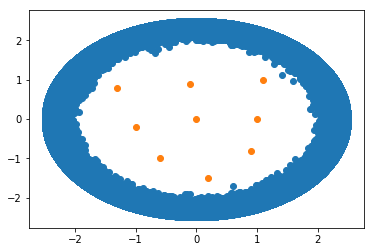

In [7]:
plt.scatter(entryTrajsStart[:,0], entryTrajsStart[:,1])
plt.scatter(minima[:,0], minima[:,1])

In [74]:
angles = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0]) + np.pi
NangularPartitions = 60
angularMap = []
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(NangularPartitions):
    angularIncrement = 2*np.pi/NangularPartitions
    idcs = np.where(np.logical_and(angles>i*angularIncrement, angles<= (i+1)*angularIncrement))[0]
    sortedEntryTrajsStart.append(entryTrajsStart[idcs])
    sortedEntryTimes.append(entryTimes[idcs])
    sortedEnds = []
    for j in idcs:
        sortedEnds.append(entryTrajsEnd[j])
    sortedEntryTrajsEnd.append(sortedEnds)

In [75]:
exitProbs = np.zeros(9)
for i in range(9):
    outgoingTrajs = 0
    for j in range(10):
        outgoingTrajs += len(transitionTrajs[i][j])   
    exitProbs[i] = len(transitionTrajs[i][9])/float(outgoingTrajs)
print exitProbs

[ 0.04703026  0.20052795  0.49541873  0.25005325  0.51548383  0.23576148
  0.27634675  0.28177217  0.42580063]


In [14]:
#resolve problem that fullDTrajs is a list of lists
trajectories = []
for traj in fullDTrajs:
    trajectories.append(traj[0])

In [31]:
#put all exit trajs into one list, from the list sorted by state
exitTrajs = []
for i in range(9):
    exitTrajs += (transitionTrajs[i][9])

In [10]:
import pyemma
import pyemma.plots as mplt
import pyemma.msm
import msmtools.estimation as est
#its = pyemma.msm.its(trajectories,  lags = 50, reversible=True)

In [81]:
fullCount = est.count_matrix(trajectories, 10)

In [82]:
exitCounts = est.count_matrix(exitTrajs, 10)

In [83]:
for i in range(9):
    print exitCounts[i,i]/fullCount[i,i]

0.10353637714
0.299283112514
0.505377820029
0.338086415195
0.518382687774
0.327049423283
0.359264763374
0.366071347232
0.45164417244


In [84]:
finalCountMatrix = 1. * fullCount
for i in range(9):
    finalCountMatrix[i,i] -= exitCounts[i,i]

In [85]:
tmatrix = est.transition_matrix(finalCountMatrix).todense()
treduced = np.copy(tmatrix[:9,:9])
for i in range(9):
    treduced[i,:] /= np.sum(treduced[i,:])
for i in range(9):
    print (treduced[i,i])

0.723123970172
0.730353687072
0.786541968063
0.777789290317
0.785682092395
0.750674970739
0.741549937787
0.7367738803
0.748094009638


In [86]:
tmatrixFull = est.transition_matrix(fullCount).todense()
treducedFull = np.copy(tmatrixFull[:9,:9])
for i in range(9):
    treducedFull[i,:] /= np.sum(treducedFull[i,:])
for i in range(9):
    print (treducedFull[i,i])

0.744465366037
0.794467697236
0.881651889095
0.840968224233
0.883880005792
0.817320606448
0.81745199036
0.815339632442
0.8441325506


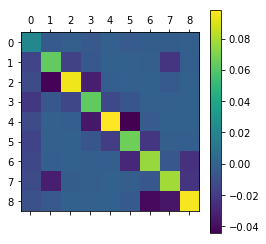

In [87]:
plt.matshow(treducedFull - treduced)
plt.colorbar()

(array([ -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.]),
 <a list of 8 Text yticklabel objects>)

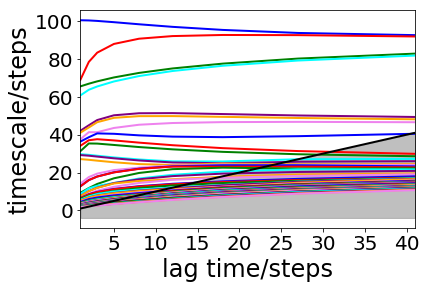

In [26]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [59]:
MSMlag = 5
M = pyemma.msm.estimate_markov_model(trajectories, lag=MSMlag)

In [60]:
for i in range(9):
    print np.sum(M.transition_matrix[i,i])

0.863827210685
0.872027106752
0.893216625959
0.897019711975
0.891811246805
0.883133662158
0.877794600941
0.874683419402
0.874752038021


In [219]:
print exitProbs

[ 0.04707718  0.20058453  0.4954896   0.25011928  0.51546322  0.23568394
  0.27641693  0.28140222  0.42587279]


In [61]:
# truncate transition matrix such that only transitions withing the inner states are allowed
Tmatrix= np.copy(M.transition_matrix[:9,:9])
for i in range(9):
    Tmatrix[i,:] /= np.sum(Tmatrix[i,:])
for i in range(9):
    print Tmatrix[i,i]

0.869488711922
0.895468792834
0.943177051203
0.920511397019
0.944797075291
0.908065748468
0.908460330621
0.906657155534
0.924231556116


In [76]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModel(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, MSMtime, tmatrix, NangularBins):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.tmatrix = tmatrix
        self.MSMtimestep = MSMtime
        self.NangularBins = NangularBins

In [88]:
model = truncTrajsModel(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositions, exitTimes, exitProbs, 0.1, treduced, NangularPartitions)